In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import poppy
import astropy.units as u
import logging
logging.basicConfig(level=logging.DEBUG)
from astropy.io import fits
from astropy.modeling import models, fitting
import tifffile
import numpy as np
import matplotlib.colors as mcolors
from astropy.stats import sigma_clip
logging.getLogger().setLevel(logging.INFO)
import photutils
import time
import datetime as dt
from numpy.linalg import lstsq
import os
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import os, re
from poppy.zernike import zernike_basis,decompose_opd
import winsound

# Colormap
dark_yellow = [ '#003f5c', '#2f4b7c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600']
custom_cmap = mcolors.LinearSegmentedColormap.from_list("DarkYellow", dark_yellow)
gradient = np.linspace(0, 1, 256).reshape(1, -1)


<span style="color:green; font-size: 2.5em;">Funzioni</span>


In [6]:
##########################################################################
##########################################################################
def parse_beam_center(fn):
    bx = by = None
    with open(fn, 'r', encoding='latin-1') as f:
        for L in f:
            if 'Beam Center X [mm]' in L:
                bx = float(L.split(',')[1])
            elif 'Beam Center Y [mm]' in L:
                by = float(L.split(',')[1])
            if bx is not None and by is not None:
                break
    if bx is None or by is None:
        raise RuntimeError("Beam center not found")
    return bx, by
##########################################################################
##########################################################################
def parse_wavefront_grid(filename):
    with open(filename, 'r', encoding='latin-1') as f:
        lines = f.readlines()
    x_coords_line = None
    for i, line in enumerate(lines):
        if line.strip().startswith("y / x [mm]"):
            x_coords_line = i
            break
    if x_coords_line is None:
        raise ValueError("X coordinates line not found")
    x_coords_str = lines[x_coords_line].split(",")[1:]
    x_coords = []
    for x in x_coords_str:
        x_clean = x.strip()
        try:
            x_coords.append(float(x_clean))
        except:
            x_coords.append(np.nan) 
    y_coords = []
    wavefront_data = []
    for line in lines[x_coords_line+1:]:
        if line.strip() == "":
            continue
        parts = line.split(",")
        if len(parts) < 2:
            continue
        y_str = parts[0].strip()
        try:
            y = float(y_str)
        except:
            continue 
        vals = []
        # Keep all columns aligned with x_coords
        for v in parts[1:]:
            v_clean = v.strip()
            try:
                vals.append(float(v_clean))
            except:
                vals.append(np.nan)  
        y_coords.append(y)
        wavefront_data.append(vals)
    wf_array = np.array(wavefront_data)
    y_coords = np.array(y_coords)
    x_coords = np.array(x_coords)
    print(f"x_coords length: {len(x_coords)}")
    print(f"wavefront_data shape: {wf_array.shape}")
    if wf_array.shape[1] != len(x_coords):
        raise ValueError("Mismatch between wavefront columns and x coordinates")
    return x_coords, y_coords, wf_array
##########################################################################
##########################################################################
def parse_zernike_coeffs(fn, n_modes):
    coeffs = []
    in_z = False
    pat = re.compile(r'\s*(\d+),\s*-?\d+,\s*-?\d+,\s*([-\d\.eE]+)')
    with open(fn, 'r', encoding='latin-1') as f:
        for L in f:
            if L.strip().startswith('*** ZERNIKE FIT ***'):
                in_z = True
                continue
            if in_z:
                m = pat.match(L)
                if m:
                    idx, c = int(m.group(1)), float(m.group(2))
                    if idx <= n_modes:
                        coeffs.append(c)
                if len(coeffs) >= n_modes:
                    break
    return np.array(coeffs)
##########################################################################
##########################################################################
def noll_to_zernike(j):
    n = 0; j1 = j - 1
    while j1 >= n+1:
        n += 1; j1 -= n
    m = -n + 2*j1
    return n, m
##########################################################################
##########################################################################
def remap_sensor_coeffs(raw, n_modes):
    rem = np.zeros(n_modes)
    for i, c in enumerate(raw, start=1):
        tgt = {2:3, 3:2}.get(i, i)
        if tgt <= n_modes:
            rem[tgt-1] = c
    return rem
##########################################################################
##########################################################################
def parse_pupil_diameter_center(fn):
    pd = None
    pcx = None
    pcy = None
    with open(fn, 'r', encoding='latin-1') as f:
        for L in f:
            if 'Pupil Diameter X [mm]' in L:
                pd = float(L.split(',')[1])
            elif 'Pupil Center X [mm]' in L:
                pcx = float(L.split(',')[1])
            elif 'Pupil Center Y [mm]' in L:
                pcy = float(L.split(',')[1])
    if pd is None or pcx is None or pcy is None:
        raise RuntimeError("Pupil diameter or center not found")
    print(f"Pupil diameter: {pd} mm, Center: ({pcx}, {pcy}) mm")
    return pd, pcx, pcy
##########################################################################
##########################################################################
def crop_to_square(arr):
    ny, nx = arr.shape
    size = min(ny, nx)
    startx = (nx - size) // 2
    starty = (ny - size) // 2
    return arr[starty:starty + size, startx:startx + size]
##########################################################################
##########################################################################
def fit_zernikes(x_coords, y_coords, wavefront_data, pupil_diameter, max_mode):  # maxmode=15
    # Normalize to unit pupil centered at 
    X_norm = x_coords / (pupil_diameter / 2)
    Y_norm = y_coords / (pupil_diameter / 2)
    X_mesh, Y_mesh = np.meshgrid(X_norm, Y_norm)
    R = np.sqrt(X_mesh**2 + Y_mesh**2)
    Theta = np.arctan2(Y_mesh, X_mesh)
    mask = R <= 1
    wf_masked = wavefront_data[mask]
    basis_stack = zernike_basis(nterms=max_mode, rho=R, theta=Theta)
    Z_mat = np.vstack([basis_stack[j][mask] for j in range(max_mode)]).T #Stacks the Zernike modes into a matrix of shape (n_points, n_modes).
    coeffs, _, _, _ = np.linalg.lstsq(Z_mat, wf_masked, rcond=None)
    # fitted wavefront
    wf_fit = np.full_like(wavefront_data, np.nan)
    fit_vals = np.sum([coeffs[j] * basis_stack[j][mask] for j in range(max_mode)], axis=0)
    wf_fit[mask] = fit_vals
    return coeffs, wf_fit
#######################################################################
#########################################################################
def code_end_alert():
    duration = 5000  # milliseconds
    freqs = [440, 550, 660, 770, 880, 990]  # A few different frequencies
    for freq in freqs:
        winsound.Beep(freq, duration // len(freqs))  # Divide duration to keep total time similar
    freqs = freqs[:-1]
    for freq in reversed(freqs):
        winsound.Beep(freq, duration // (len(freqs)+1))
    print("Code execution completed")
##########################################################################
##########################################################################
    
def data_loading(file_name):
    match = re.search(r'elev(\d{2})', file_name)
    if match:
        elevation = int(match.group(1))
        print(f"Elevation extracted: {elevation}")
        return elevation
    else:
        raise ValueError(f"Elevation not found in file name: {file_name}")
#########################################################################
##########################################################################
def zernike_wfe_analysis(file,elevation,n_modes,exclude_low,output_dir):
    results=[]
    
    if output_dir is None:
        output_dir = os.getcwd()
    os.makedirs(output_dir, exist_ok=True)
    #lettura dati
    x_coords, y_coords, wavefront_data = parse_wavefront_grid(file)
    pupil_diameter, pupil_center_x, pupil_center_y = parse_pupil_diameter_center(file)
    # griglia
    X_norm = (x_coords-pupil_center_x) / (pupil_diameter / 2)
    Y_norm = (y_coords-pupil_center_y) / (pupil_diameter / 2)
    X_mesh, Y_mesh = np.meshgrid(X_norm, Y_norm)
    R = np.sqrt(X_mesh**2 + Y_mesh**2)
    Theta = np.arctan2(Y_mesh, X_mesh)
    mask = R <= 1
    # Zernike basis 
    basis_stack = zernike_basis(nterms=n_modes, rho=R, theta=Theta)
    # fit coefficienti
    Z_mat = np.vstack([basis_stack[j][mask] for j in range(n_modes)]).T
    coeffs, _, _, _ = np.linalg.lstsq(Z_mat, wavefront_data[mask], rcond=None)
    # fitted wavefront
    #wavefront_total = np.full_like(wavefront_data, np.nan)
    wavefront_total = np.zeros_like(wavefront_data)
    fit_vals = np.sum([coeffs[j] * basis_stack[j][mask] for j in range(n_modes)], axis=0)
    wavefront_total[mask] = fit_vals
    
    ########################################################################################
    #for i, c in enumerate(coeffs, 1):
    #    print(f"Mode {i}: {c:.6f} ")#µm"
    #SOTTRAZIONE PRIMI TERMINI #############
    wf_low = np.zeros_like(wavefront_data)
    for j in range(exclude_low):
        wf_low[mask] += coeffs[j] * basis_stack[j][mask]
    wf_high = wavefront_total - wf_low
    
    # risultati
    residuals_total = wavefront_data - wavefront_total
    residuals_low = wavefront_data - wf_low
    residuals_high = wavefront_data - wf_high
    rms_wfe = np.sqrt(np.nanmean(residuals_high**2))
    pv_wfe = np.nanmax(residuals_high) - np.nanmin(residuals_high)
    
    results.append({
        'filename': file,
        'elevation': elevation,
        'rms_wfe': rms_wfe,
        'pv_wfe': pv_wfe,
        'coeffs': coeffs,
    })
    
    return results, wavefront_total, wf_low, wf_high, residuals_total, residuals_low, residuals_high

<span style="color:blue; font-size: 2.5em;">Grafici </span>

In [7]:
def plot_wavefront(x_coords, y_coords, wf_array, title=None):
    fig, ax = plt.subplots(figsize=(12, 6))
    im = ax.imshow(wf_array, extent=(x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()),
                   origin='upper', cmap='jet', aspect='auto')
    ax.set_xlabel('X [mm]')
    ax.set_ylabel('Y [mm]')
    if title:
        ax.set_title(title)
    plt.colorbar(im, ax=ax, label='Wavefront Error [µm]')
    plt.show()
#######################################################################################################
#######################################################################################################
# Plotting function
def plot_wavefront_new(x_coords, y_coords, wf_array, title=None, cmap='jet'):
    # Filter out NaN values
    x_coords_valid = x_coords[~np.isnan(x_coords)]
    y_coords_valid = y_coords[~np.isnan(y_coords)]

    plt.figure(figsize=(12, 5))
    plt.imshow(wf_array, extent=(x_coords_valid.min(), x_coords_valid.max(), y_coords_valid.min(), y_coords_valid.max()),
               origin='upper', cmap=cmap, aspect='auto')
    plt.xlabel('X [mm]')
    plt.ylabel('Y [mm]')
    if title:
        plt.title(title)
    plt.colorbar(label='Wavefront Error [µm]')
    plt.show()
    #######################################################################################################
#######################################################################################################
def plot_wavefronts(x_coords, y_coords, wavefront_data, wavefront_fit):
    extent = [
    np.nanmin(x_coords),
    np.nanmax(x_coords),
    np.nanmin(y_coords),
    np.nanmax(y_coords),
]

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    im0 = axs[0].imshow(wavefront_data, extent=extent, origin='upper', cmap='jet')
    axs[0].set_title('Measured Wavefront')
    axs[0].set_xlabel('X [mm]')
    axs[0].set_ylabel('Y [mm]')
    plt.colorbar(im0, ax=axs[0], label='[μm]')

    im1 = axs[1].imshow(wavefront_fit, extent=extent, origin='upper', cmap='jet')
    axs[1].set_title('Reconstructed fitted Wavefront')
    axs[1].set_xlabel('X [mm]')
    axs[1].set_ylabel('Y [mm]')
    plt.colorbar(im1, ax=axs[1], label=' [μm]')

    plt.tight_layout()
    plt.show()
#######################################################################################################
#######################################################################################################
def plot_wavefront_residuals(x_coords, y_coords, wavefront_data, wavefront_fit_2, title='Zernike Fit Residuals'):
    wavefront_fit_2 = np.nan_to_num(wavefront_fit_2, nan=0.0)
    residuals = np.nan_to_num(wavefront_data - wavefront_fit_2, nan=0.0)
    plot_wavefront_new(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], residuals, title=title)

<span style="color:yellow; font-size: 2.5em;">Variabili in input </span>

In [8]:


file = (r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus")
directory = r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus"
filenumber = 9 # sceglie il file specifico nella cartella directory
#pupil_diameter = 5.8  # mm
orders =  30
n_modes = 27
#pixel_scale = 0.150  # mm/pixel SPAZIATURE DEGLI SPOT NEL PIANO, NON LA REALE DIMENSIONE DEI PIXEL (QUELLA è 5.86 micron)


In [148]:
code_end_alert()

Code execution completed



<span style="color:orange; font-size: 2.5em;">Codice </span>

x_coords length: 74
wavefront_data shape: (45, 74)
Pupil diameter: 5.8 mm, Center: (0.05, -0.056) mm


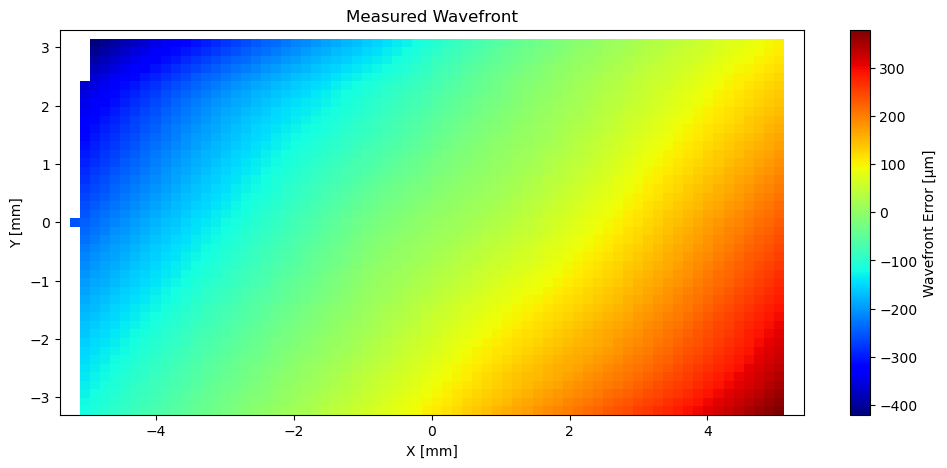

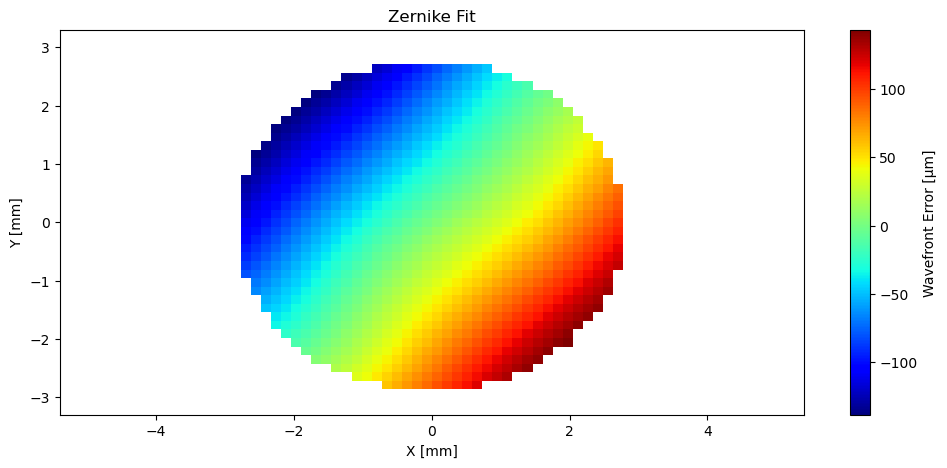

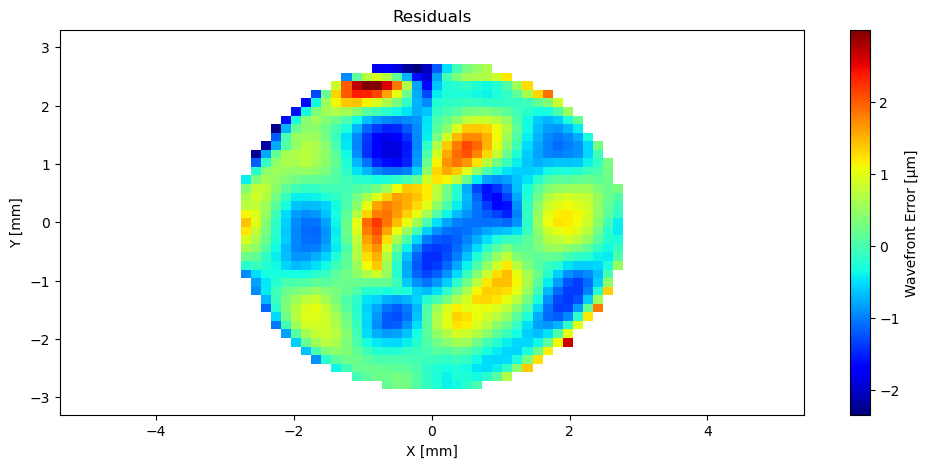

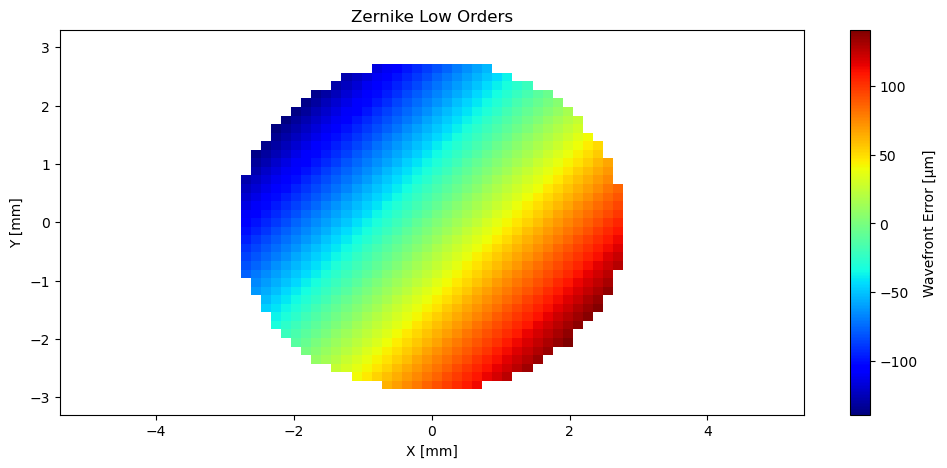

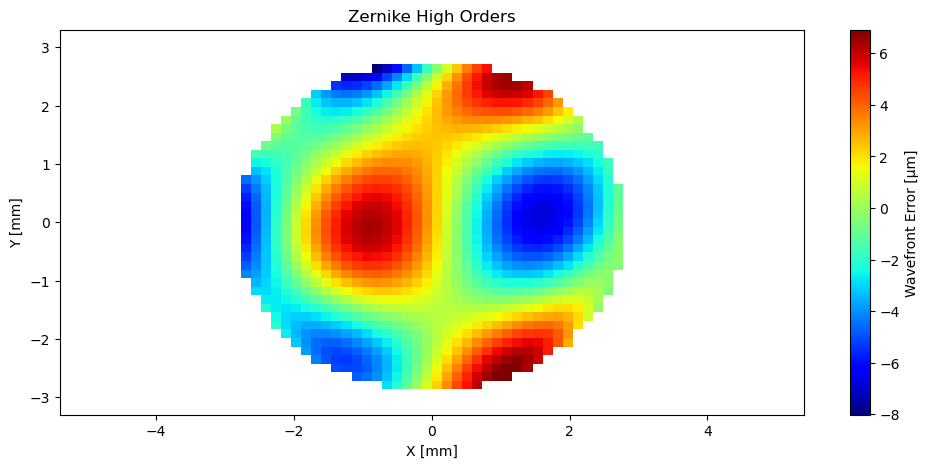

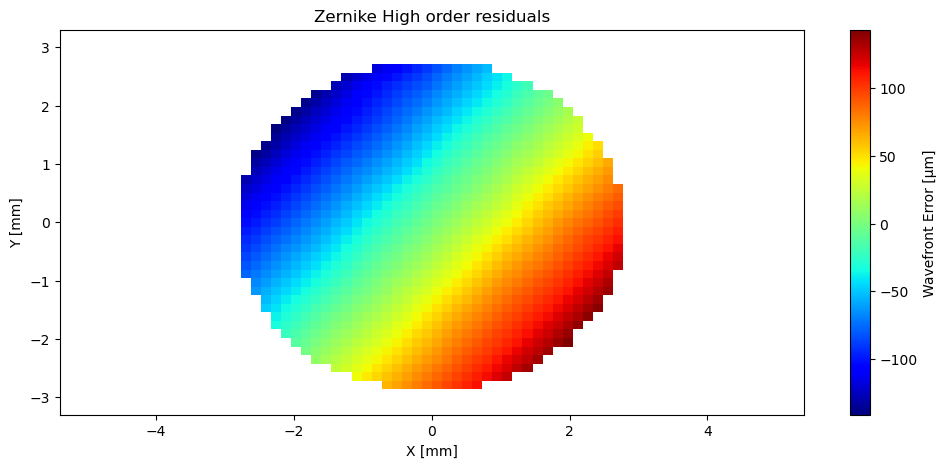

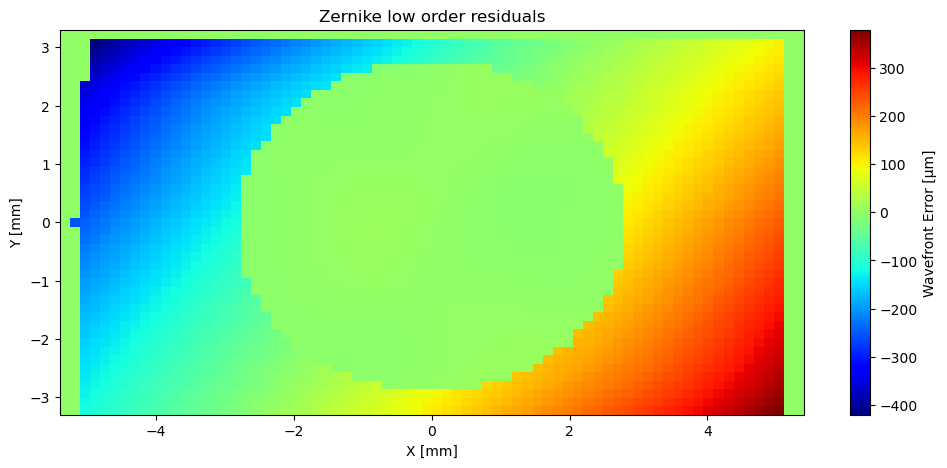

In [ ]:

files = [f for f in os.listdir(directory) if f.endswith('.csv')]
if not files:
    raise FileNotFoundError("No CSV files found in directory")
filename = files[filenumber]
full_path = os.path.join(directory, filename)
file = full_path  

##### Lettura dati ##############################################################
x_coords, y_coords, wavefront_data = parse_wavefront_grid(file)
pupil_diameter, pupil_center_x, pupil_center_y = parse_pupil_diameter_center(file)
#######################################################################################
######## costruzione griglia  ##################################à
#orders =  15 # 7 ideale
#n_modes = (orders + 1) * (orders + 2) // 2
X_norm = (x_coords-pupil_center_x) / (pupil_diameter / 2)
Y_norm = (y_coords-pupil_center_y) / (pupil_diameter / 2)
X_mesh, Y_mesh = np.meshgrid(X_norm, Y_norm)
R = np.sqrt(X_mesh**2 + Y_mesh**2)
Theta = np.arctan2(Y_mesh, X_mesh)
mask = R <= 1
#########################################################################
# Create Zernike basis 
basis_stack = zernike_basis(nterms=n_modes, rho=R, theta=Theta)
#fit the wavefront with Zernike basis
Z_mat = np.vstack([basis_stack[j][mask] for j in range(n_modes)]).T
coeffs, _, _, _ = np.linalg.lstsq(Z_mat, wavefront_data[mask], rcond=None)
# Create fitted wavefront
wavefront_fit = np.full_like(wavefront_data, np.nan)
fit_vals = np.sum([coeffs[j] * basis_stack[j][mask] for j in range(n_modes)], axis=0)
wavefront_fit[mask] = fit_vals
residuals = wavefront_data - wavefront_fit
########################################################################################
#for i, c in enumerate(coeffs, 1):
#    print(f"Mode {i}: {c:.6f} ")#µm"
#################### FIT TOTALE E SOTTRAZIONE PRIMI TERMINI #############
#basis_stack = zernike_basis(nterms=n_modes, rho=R, theta=Theta)
#Z_mat = np.vstack([basis_stack[j][mask] for j in range(n_modes)]).T
#coeffs, _, _, _ = np.linalg.lstsq(Z_mat, wavefront_data[mask], rcond=None)
#wf_total = sum(coeffs[j] * basis_stack[j] for j in range(n_modes))
wf_low = sum(coeffs[j] * basis_stack[j] for j in range(3))  # cambiare quello ignora gradualmente più fattori 
wf_high = wavefront_fit - wf_low
residuals_low = wavefront_data - wf_low
residuals_high = wavefront_data - wf_high

#####################   grafici  ####################################################
# Plot measured wavefront
plot_wavefront_new(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], wavefront_data, title='Measured Wavefront')
# Plot Zernike
plot_wavefront_new(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], wavefront_fit, title='Zernike Fit')
#residuals
plot_wavefront_new(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], residuals, title='Residuals')
#wavefront_fit = np.nan_to_num(wavefront_fit, nan=0.0)
#print(wavefront_fit.shape)
#residuals = np.nan_to_num(wavefront_data - wavefront_fit, nan=0.0)
#plot_wavefront_new(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], residuals, title='Zernike fit residuals')

plot_wavefront_new(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], wf_low, title='Zernike Low Orders')
plot_wavefront_new(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], wf_high, title='Zernike High Orders')
wf_total = np.nan_to_num(wavefront_fit, nan=0.0)
wf_high= np.nan_to_num(wf_high, nan=0.0)
wf_low = np.nan_to_num(wf_low, nan=0.0)
residuals_low = np.nan_to_num(wavefront_data - wf_low, nan=0.0)   # residui dovuti ai termini id basso ordine
residual_high = np.nan_to_num(wavefront_data - wf_high, nan=0.0)  # residui dei temini di alto ordine
plot_wavefront_new(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], residuals_high, title='Zernike High order residuals')
plot_wavefront_residuals(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], wavefront_data, wf_low, title='Zernike low order residuals')



<span style="color:Green; font-size: 2.5em;">Beta </span>

In [ ]:
from astropy.table import Table
import pandas as pd


def build_dataframe(results_all):
    records = []
    for res in results_all:
        rec = {
            'filename': os.path.basename(res['filename']),
            'rms_wfe': res['rms_wfe'],
            'pv_wfe': res['pv_wfe']
        }
        coeffs = res['coeffs']

        for i, c in enumerate(coeffs):
            rec[f'coeff_{i}'] = c
        records.append(rec)
    df = pd.DataFrame.from_records(records)
    return df

def save_metrics_as_fits(df, out_fits):
    t = Table.from_pandas(df)
    hdu_table = fits.BinTableHDU(data=t, name='METRICS')
    primary = fits.PrimaryHDU()
    primary.header['COMMENT'] = "Zernike WFE analysis metrics"
    hdul = fits.HDUList([primary, hdu_table])
    hdul.writeto(out_fits, overwrite=True)
    print(f"Tabella FITS salvata in {out_fits}")

def save_wavefront_cube(wf_list, filenames, out_fits, extname_prefix):
    """
    wf_list: lista di 2D array (Ny,Nx), length N_files
    filenames: lista di basename corrispondenti
    """
    shape0 = wf_list[0].shape
    for arr in wf_list:
        if arr.shape != shape0:
            raise ValueError("Shape diversa tra wavefront; riallinea/interpola prima")
    cube = np.stack(wf_list, axis=0).astype(np.float32)  # (N,Ny,Nx)
 
    hdu_primary = fits.PrimaryHDU(data=cube)
    hdu_primary.header['COMMENT'] = f"Cube {extname_prefix}: dim (N_files, Ny, Nx)"

    indices = np.arange(len(filenames), dtype=np.int32)
    maxlen = max(len(fn) for fn in filenames)
    col_idx = fits.Column(name='index', format='K', array=indices)
    col_fn  = fits.Column(name='filename', format=f'A{maxlen}', array=np.array(filenames, dtype=f'U{maxlen}'))
    table_hdu = fits.BinTableHDU.from_columns([col_idx, col_fn], name=f'{extname_prefix}_FILES')
    hdul = fits.HDUList([hdu_primary, table_hdu])
    hdul.writeto(out_fits, overwrite=True)
    hdul.close()
    print(f"Saved cube {extname_prefix} in: {out_fits}")

def data_loading(file):
    #match = re.search(r'elev(\d{2})', file)
    #if match:
    #    elevation = int(match.group(1))
    #    print(f"Elevation extracted: {elevation}")
    #else:
    #    raise ValueError(f"Elevation not found in file name: {file}")
    x_coords, y_coords, wavefront_data = parse_wavefront_grid(file)
    pupil_diameter, pupil_center_x, pupil_center_y = parse_pupil_diameter_center(file)
    return x_coords, y_coords, wavefront_data, pupil_diameter, pupil_center_x, pupil_center_y  #, elevation

def zernike_wfe_analysis(file,n_modes,exclude_low):
    results_single_file=[]
    
#C'ERA ELEVATION ANCHE
    x_coords, y_coords, wavefront_data, pupil_diameter, pupil_center_x, pupil_center_y = data_loading(file)
    
    # griglia
    X_norm = (x_coords-pupil_center_x) / (pupil_diameter / 2)
    Y_norm = (y_coords-pupil_center_y) / (pupil_diameter / 2)
    X_mesh, Y_mesh = np.meshgrid(X_norm, Y_norm)
    R = np.sqrt(X_mesh**2 + Y_mesh**2)
    Theta = np.arctan2(Y_mesh, X_mesh)
    mask = R <= 1
    # Zernike basis 
    basis_stack = zernike_basis(nterms=n_modes, rho=R, theta=Theta)
    # fit coefficienti
    Z_mat = np.vstack([basis_stack[j][mask] for j in range(n_modes)]).T
    coeffs, _, _, _ = np.linalg.lstsq(Z_mat, wavefront_data[mask], rcond=None)
    # fitted wavefront
    #wavefront_total = np.full_like(wavefront_data, np.nan)
    wavefront_total = np.zeros_like(wavefront_data)
    fit_vals = np.sum([coeffs[j] * basis_stack[j][mask] for j in range(n_modes)], axis=0)
    wavefront_total[mask] = fit_vals
    ########################################################################################
    #for i, c in enumerate(coeffs, 0):
    #    print(f"Mode {i}: {c:.6f} ")#µm"
    #SOTTRAZIONE PRIMI TERMINI #############
    wf_low = np.zeros_like(wavefront_data)
    for j in range(exclude_low):
        wf_low[mask] += coeffs[j] * basis_stack[j][mask]
    wf_high = wavefront_total - wf_low
    
    # risultati
    residuals_total = wavefront_data - wavefront_total
    residuals_low = wavefront_data - wf_low
    residuals_high = wavefront_data - wf_high
    rms_wfe = np.sqrt(np.nanmean(residuals_high**2))
    pv_wfe = np.nanmax(residuals_high) - np.nanmin(residuals_high)
    
    results_single_file = {
        'filename': file,
        'rms_wfe': rms_wfe,
        'pv_wfe': pv_wfe,
        'coeffs': coeffs,
        'residuals_total': residuals_total,
        'residuals_low': residuals_low,
        'residuals_high': residuals_high,
        'wavefront_total': wavefront_total,
        'wavefront_low': wf_low,
        'wavefront_high': wf_high
    }
    return [results_single_file]

########################## MAIN ##########################################################
files = [f for f in os.listdir(directory) if f.endswith('.csv')]
print(f"Found {len(files)} files in the folder")
if not files:
    raise FileNotFoundError("No CSV files found in directory")

exclude_low = 3  # Number of Zernike modes to exclude

results_all = []
wf_total_list = []
wf_low_list = []
wf_high_list = []
res_total_list = []
res_low_list = []
res_high_list = []
filenames = []

for filenumber in range(len(files)):
    results_single_file = []
    filename = files[filenumber]
    full_path = os.path.join(directory, filename)
    file = full_path
    print(f"Processing {full_path}...")
    try:
        results_single_file = zernike_wfe_analysis(full_path, n_modes, exclude_low)
    except Exception as e:
        print(f"  Skip {file}: {e}")
        continue
     # results_single_file è lista con un dict
    res = results_single_file[0]
    results_all.append(res)
    filenames.append(os.path.basename(res['filename']))
    wf_total_list.append(res['wavefront_total'])
    wf_low_list.append(res['wavefront_low'])
    wf_high_list.append(res['wavefront_high'])
    res_total_list.append(res['residuals_total'])
    res_low_list.append(res['residuals_low'])
    res_high_list.append(res['residuals_high'])

os.makedirs('results', exist_ok=True)
  
df = build_dataframe(results_all)
csv_out = os.path.join('results', 'wfe_all_results.csv')
df.to_csv(csv_out, index=False)
print(f"CSV salvato in: {csv_out}")
fits_out = os.path.join('results', 'wfe_metrics.fits')
save_metrics_as_fits(df, fits_out)  

save_wavefront_cube(wf_total_list, filenames, os.path.join('results','wavefront_total_cube.fits'), 'WFTOTAL')
save_wavefront_cube(wf_low_list,   filenames, os.path.join('results','wavefront_low_cube.fits'),   'WFLOW')
save_wavefront_cube(wf_high_list,  filenames, os.path.join('results','wavefront_high_cube.fits'),  'WFHIGH')
save_wavefront_cube(res_total_list, filenames, os.path.join('results','residuals_total_cube.fits'), 'RSTOTAL')
save_wavefront_cube(res_low_list,   filenames, os.path.join('results','residuals_low_cube.fits'),   'RSLOW')
save_wavefront_cube(res_high_list,  filenames, os.path.join('results','residuals_high_cube.fits'),  'RSHIGH')
  
code_end_alert()
#     all_results.append(results_single_file)

# df = build_dataframe(all_results)



# ######## SALVATAGGIO FILE ##################à
# os.makedirs('results', exist_ok=True)
# csv_out = os.path.join('results', directory, '_all.csv')
# df.to_csv(csv_out, index=False)
# print(f"CSV salvato in {csv_out}")

# fits_out = os.path.join('results', directory, '_all.fits')
# save_metrics_as_fits(df, fits_out)














# ##### Lettura dati ########################
# x_coords, y_coords, wavefront_data = parse_wavefront_grid(file)
# pupil_diameter, pupil_center_x, pupil_center_y = parse_pupil_diameter_center(file)

# #coeffs, wavefront_fit = fit_zernikes(x_coords, y_coords, wavefront_data, pupil_diameter, nterms)
# #for i, c in enumerate(coeffs, 1):
# #    print(f"Mode {i}: {c:.6f} ")#µm")
# #plot_wavefronts(x_coords, y_coords, wavefront_data, wavefront_fit)

# orders = 30
# n_modes = (orders + 1) * (orders + 2) // 2
# X_norm = (x_coords-pupil_center_x) / (pupil_diameter / 2)
# Y_norm = (y_coords-pupil_center_y) / (pupil_diameter / 2)
# X_mesh, Y_mesh = np.meshgrid(X_norm, Y_norm)
# R = np.sqrt(X_mesh**2 + Y_mesh**2)
# Theta = np.arctan2(Y_mesh, X_mesh)
# mask = R <= 1

# basis_stack = zernike_basis(nterms=n_modes, rho=R, theta=Theta)

# #fit the wavefront using the calculated Zernike basis
# Z_mat = np.vstack([basis_stack[j][mask] for j in range(n_modes)]).T
# coeffs, _, _, _ = np.linalg.lstsq(Z_mat, wavefront_data[mask], rcond=None)
# # Create fitted wavefront
# wavefront_fit_2 = np.full_like(wavefront_data, np.nan)
# fit_vals = np.sum([coeffs[j] * basis_stack[j][mask] for j in range(n_modes)], axis=0)
# wavefront_fit_2[mask] = fit_vals

# for i, c in enumerate(coeffs, 1):
#     print(f"Mode {i}: {c:.6f} ")#µm"


# residuals = wavefront_data - wavefront_fit_2

# # Plot measured wavefront
# plot_wavefront_new(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], wavefront_data, title='Measured Wavefront')
# # Plot Zernike
# plot_wavefront_new(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], wavefront_fit_2, title='Zernike Fit')
# #residuals
# plot_wavefront_new(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], residuals, title='Residuals')


# print("Residuals shape:", residuals.shape)
# print("Residual min (ignoring NaNs):", np.nanmin(residuals))

# #########################################################################à
# wavefront_fit_2 = np.nan_to_num(wavefront_fit_2, nan=0.0)
# print(wavefront_fit_2.shape)
# residuals = np.nan_to_num(wavefront_data - wavefront_fit_2, nan=0.0)
# plot_wavefront_new(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], residuals, title='Zernike fit residuals')



Found 20 files in the folder
Processing C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus\1.csv...
x_coords length: 74
wavefront_data shape: (45, 74)
Pupil diameter: 5.8 mm, Center: (0.05, -0.056) mm
Processing C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus\10.csv...
x_coords length: 74
wavefront_data shape: (45, 74)
Pupil diameter: 5.8 mm, Center: (0.05, -0.056) mm
Processing C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus\11.csv...
x_coords length: 74
wavefront_data shape: (45, 74)
Pupil diameter: 5.8 mm, Center: (0.05, -0.056) mm
Processing C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus\12.csv...
x_coords length: 74
wavefront_data sh

PermissionError: [WinError 32] Impossibile accedere al file. Il file è utilizzato da un altro processo: 'results\\residuals_total_cube.fits'

In [12]:
df

,filename,rms_wfe,pv_wfe,coeff_0,coeff_1,coeff_2,coeff_3,coeff_4,coeff_5,coeff_6,...,coeff_17,coeff_18,coeff_19,coeff_20,coeff_21,coeff_22,coeff_23,coeff_24,coeff_25,coeff_26
0,1.csv,144.374516,790.484,0.372331,52.792398,-45.703226,-0.797274,-0.167480,-0.818911,-0.466322,...,0.477873,0.374285,0.717100,-0.193312,-0.168591,0.064590,0.038776,-0.006050,-0.009334,0.098245
1,10.csv,147.431191,807.940,0.044521,54.270357,-45.469497,-1.104184,-0.062145,-0.949264,-0.526190,...,0.499928,0.449057,1.006980,-0.363356,-0.176503,0.111599,0.064768,0.003046,-0.036983,0.168734
2,11.csv,144.071482,777.564,0.606144,53.003322,-44.974660,-0.636950,-0.265808,-1.244496,-0.189169,...,0.561522,0.237390,0.751289,-0.086357,-0.130901,0.050348,-0.012791,0.028181,0.033606,0.024707
3,12.csv,144.191816,792.551,0.230836,52.926535,-45.388763,-0.929325,-0.135326,-1.172921,-0.384361,...,0.452964,0.355692,0.762695,-0.219599,-0.143169,0.069436,0.064395,-0.038131,0.003943,0.228970
4,13.csv,144.410908,788.424,0.414211,53.181157,-45.121430,-0.728429,-0.375563,-1.212194,-0.159927,...,0.490828,0.212445,0.631397,-0.023755,-0.114276,0.040966,-0.019431,0.054646,0.035199,0.012596
5,14.csv,146.268156,791.216,0.732663,54.012819,-44.851646,-0.644186,-0.150275,-1.157560,-0.312178,...,0.582997,0.272743,0.790304,-0.250713,-0.103641,0.073972,-0.014509,0.093100,0.045011,0.045965
6,15.csv,148.118074,815.205,-0.280725,54.628484,-45.342754,-1.449106,-0.312686,-0.526598,-0.601796,...,0.409198,0.487474,1.150689,-0.385615,-0.163679,0.167579,0.073571,-0.123790,-0.027173,0.280917
7,16.csv,147.393760,804.953,0.076287,54.459370,-45.509462,-1.112858,-0.185833,-0.684483,-0.579380,...,0.560688,0.498432,0.971468,-0.369602,-0.190594,0.114060,0.056385,0.006435,-0.132632,0.036096
8,17.csv,148.428859,814.201,0.229252,54.375490,-45.768464,-1.068787,-0.141643,-0.538339,-0.756501,...,0.519722,0.517706,0.876282,-0.382976,-0.217882,0.114569,0.062172,0.001313,-0.035595,0.090309
9,18.csv,147.085252,800.396,0.356144,54.442078,-44.909534,-0.853363,-0.412339,-1.102918,-0.281173,...,0.519082,0.354837,0.888160,-0.190095,-0.154704,0.121480,0.020331,0.014531,-0.014388,0.146538


<span style="color:Yellow; font-size: 2.5em;">Delta </span>

x_coords length: 74
wavefront_data shape: (45, 74)
Pupil diameter: 5.8 mm, Center: (0.05, -0.056) mm


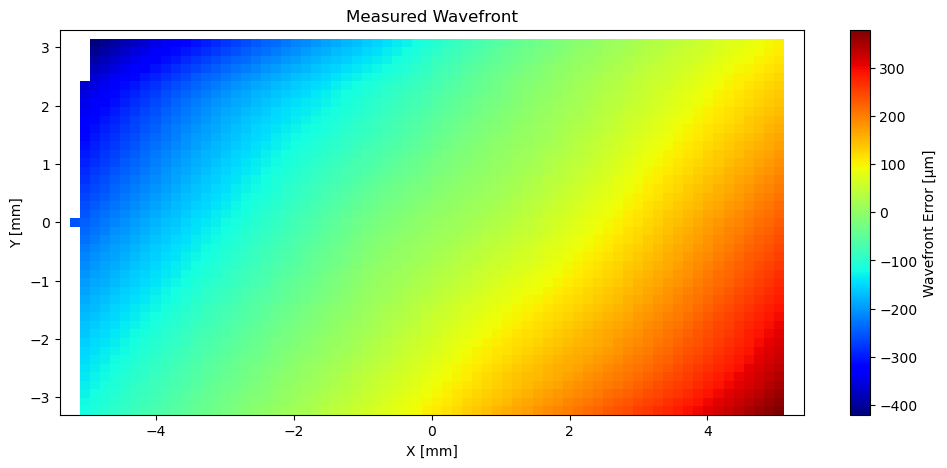

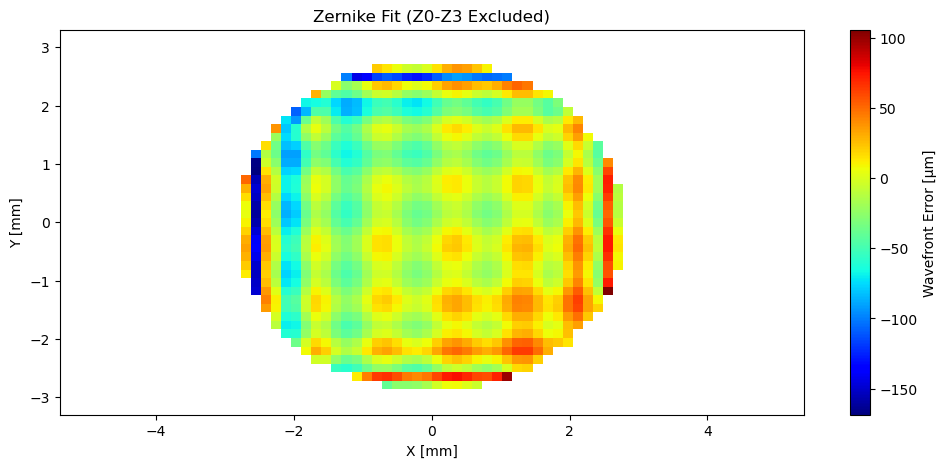

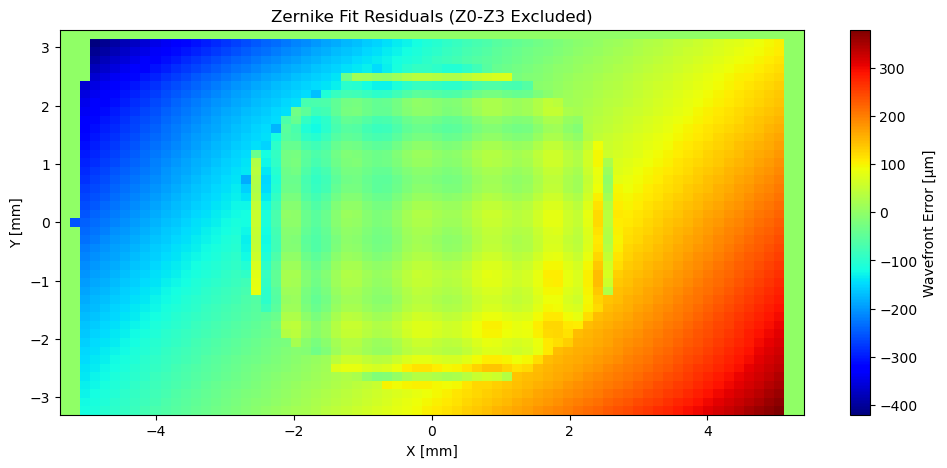

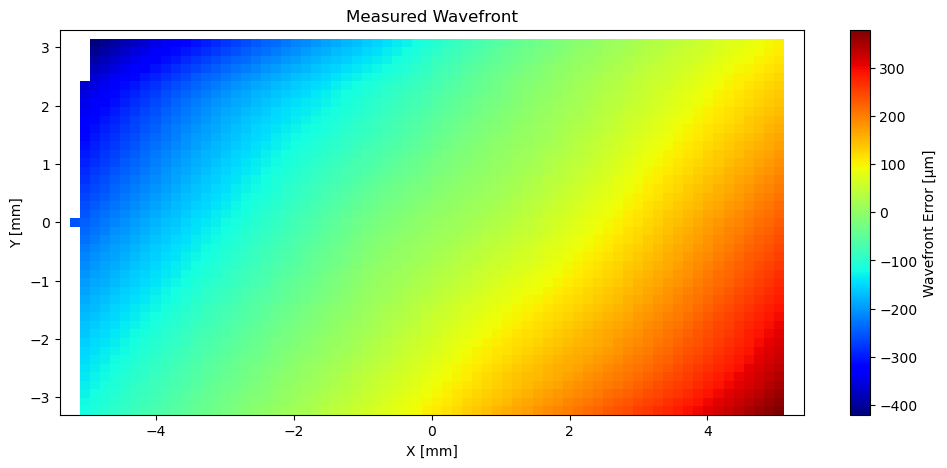

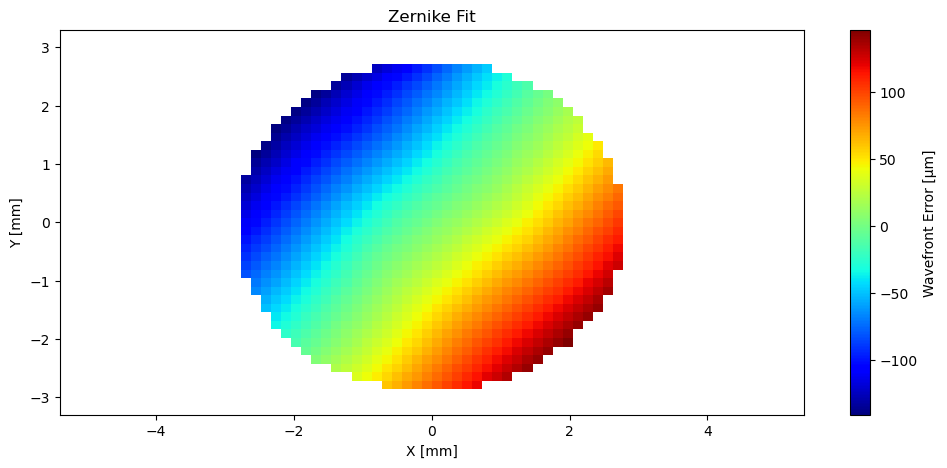

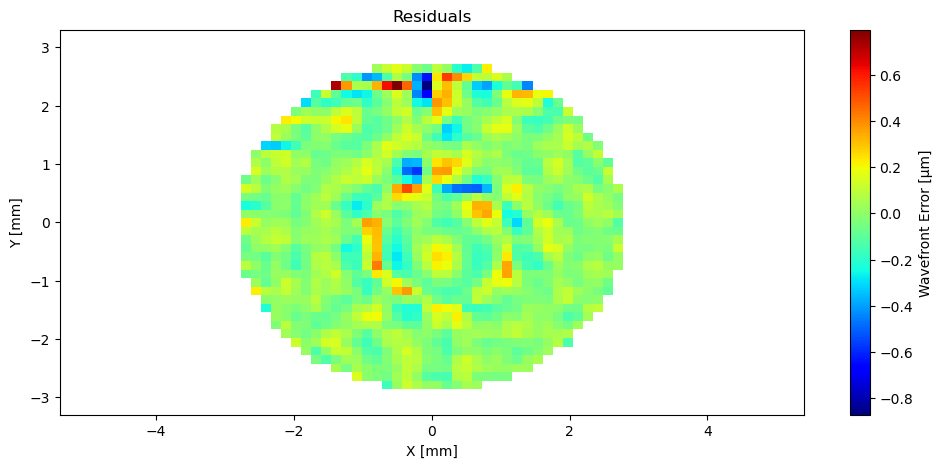

(45, 74)


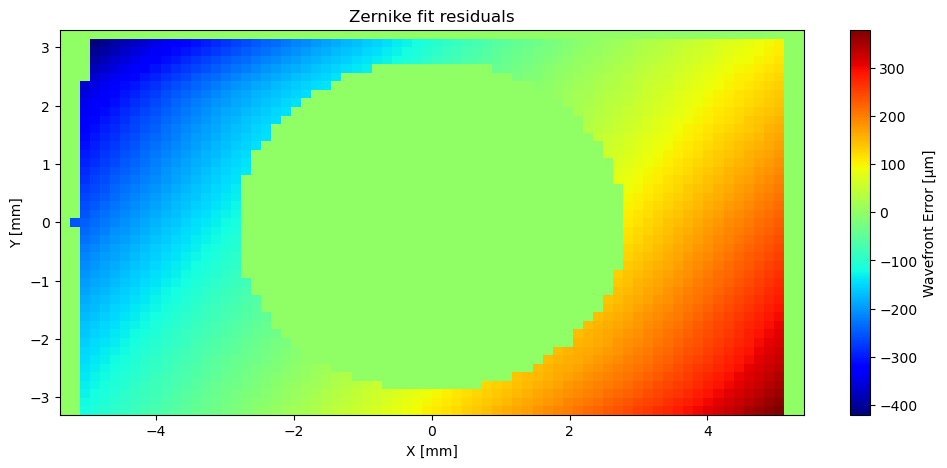

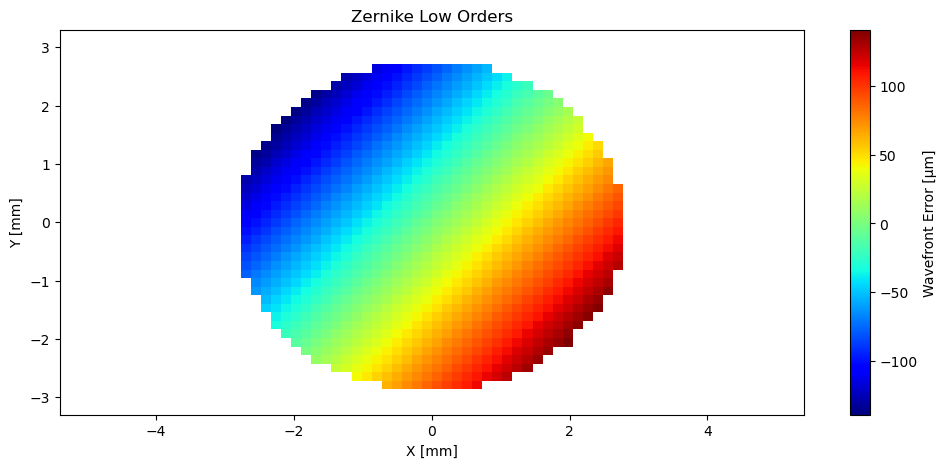

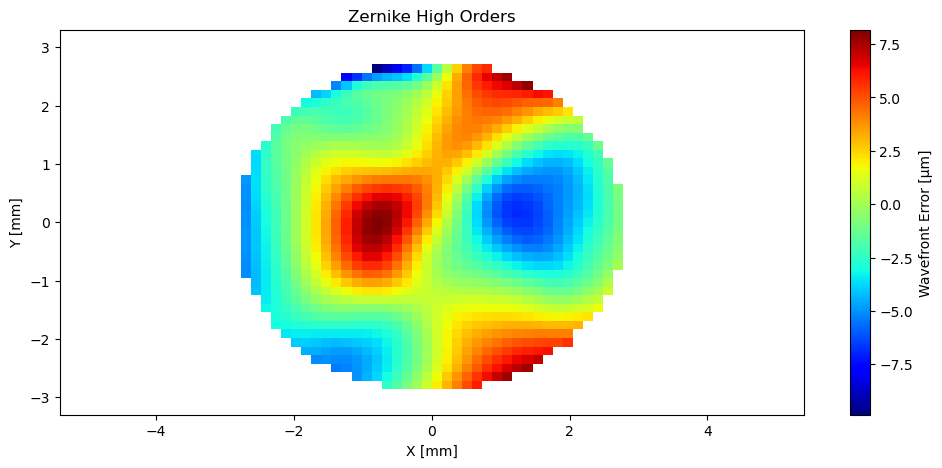

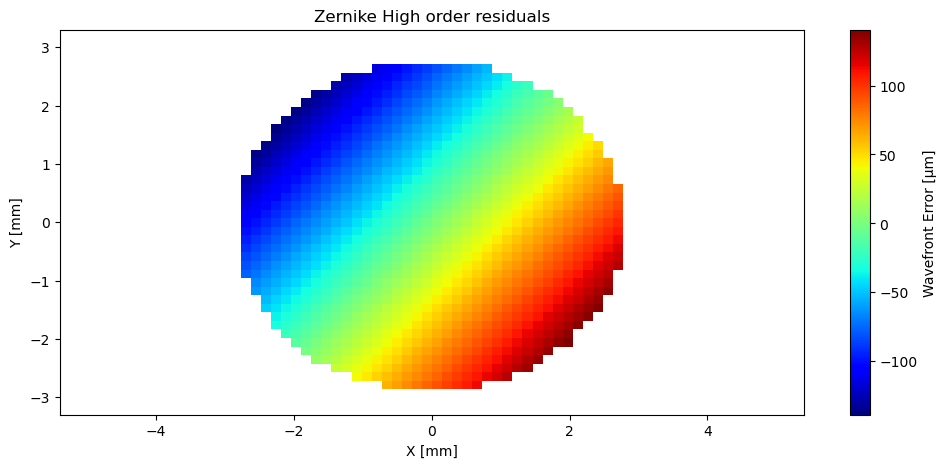

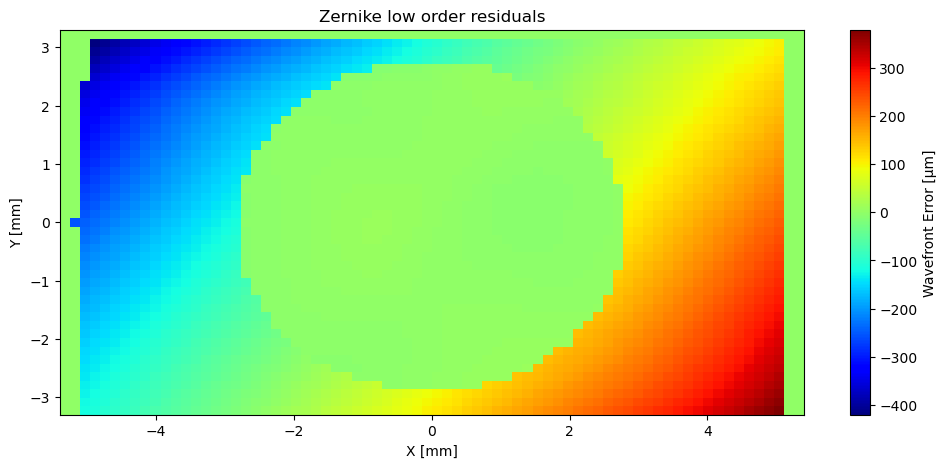

In [138]:

files = [f for f in os.listdir(directory) if f.endswith('.csv')]
if not files:
    raise FileNotFoundError("No CSV files found in directory")
filename = files[filenumber]
full_path = os.path.join(directory, filename)
file = full_path  

##### Lettura dati ########################
x_coords, y_coords, wavefront_data = parse_wavefront_grid(file)
pupil_diameter, pupil_center_x, pupil_center_y = parse_pupil_diameter_center(file)


orders =  15 # 7 ideale
n_modes = (orders + 1) * (orders + 2) // 2
X_norm = (x_coords-pupil_center_x) / (pupil_diameter / 2)
Y_norm = (y_coords-pupil_center_y) / (pupil_diameter / 2)
X_mesh, Y_mesh = np.meshgrid(X_norm, Y_norm)
R = np.sqrt(X_mesh**2 + Y_mesh**2)
Theta = np.arctan2(Y_mesh, X_mesh)
mask = R <= 1

basis_stack = zernike_basis(nterms=n_modes, rho=R, theta=Theta)
#fit the wavefront using the Zernike basis
Z_mat = np.vstack([basis_stack[j][mask] for j in range(n_modes)]).T
coeffs, _, _, _ = np.linalg.lstsq(Z_mat, wavefront_data[mask], rcond=None)
# Create fitted wavefront
wavefront_fit_2 = np.full_like(wavefront_data, np.nan)
fit_vals = np.sum([coeffs[j] * basis_stack[j][mask] for j in range(n_modes)], axis=0)
wavefront_fit_2[mask] = fit_vals
residuals = wavefront_data - wavefront_fit_2
#print("Mask pixel count:", mask.sum())
#print("R min/max:", np.nanmin(R), np.nanmax(R))
#for i, b in enumerate(basis_stack):
#    print(f"Mode {i}: min {np.nanmin(b):.3f}, max {np.nanmax(b):.3f}, NaNs {np.isnan(b).sum()}")


############################## termini zernike azzerati fino a defocus
# Calcolo base Zernike completa
basis_stack = zernike_basis(nterms=n_modes, rho=R, theta=Theta)
# Escludi i primi 4 modi (Z1–Z4) dalla base
basis_stack_no_low = basis_stack[3:]
#basis_stack_no_low = np.copy(basis_stack)
#basis_stack_no_low[:3] = 0
n_modes_no_low = len(basis_stack_no_low)
# Ricostruzione della matrice Zernike escludendo Z1–Z4
Z_mat_no_low = np.vstack([basis_stack_no_low[j][mask] for j in range(n_modes_no_low)]).T
coeffs_no_low, _, _, _ = np.linalg.lstsq(Z_mat_no_low, wavefront_data[mask], rcond=None)
# Riostruzione del fronte d’onda
wavefront_fit_no_low = np.full_like(wavefront_data, np.nan)
fit_vals_no_low = np.sum([coeffs_no_low[j] * basis_stack_no_low[j][mask] for j in range(n_modes_no_low)], axis=0)
wavefront_fit_no_low[mask] = fit_vals_no_low
residuals_no_low = wavefront_data - wavefront_fit_no_low



plot_wavefront_new(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], wavefront_data, title='Measured Wavefront')
plot_wavefront_new(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], wavefront_fit_no_low, title='Zernike Fit (Z0-Z3 Excluded)')
plot_wavefront_residuals(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], wavefront_data, wavefront_fit_no_low, title='Zernike Fit Residuals (Z0-Z3 Excluded)')

#for i, c in enumerate(coeffs_no_low, 1):
#    print(f"Mode {i+(len(basis_stack)-len(basis_stack_no_low))}: {c:.6f} ")#µm"
########################################################################################
#for i, c in enumerate(coeffs, 1):
#    print(f"Mode {i}: {c:.6f} ")#µm"

# Plot measured wavefront
plot_wavefront_new(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], wavefront_data, title='Measured Wavefront')
# Plot Zernike
plot_wavefront_new(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], wavefront_fit_2, title='Zernike Fit')
#residuals
plot_wavefront_new(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], residuals, title='Residuals')


#########################################################################à
wavefront_fit_2 = np.nan_to_num(wavefront_fit_2, nan=0.0)
print(wavefront_fit_2.shape)
residuals = np.nan_to_num(wavefront_data - wavefront_fit_2, nan=0.0)
plot_wavefront_new(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], residuals, title='Zernike fit residuals')


#################### TENTATIVI CON FIT TOTALE E SOTTRAZIONE PRIMI TERMINI#############

basis_stack = zernike_basis(nterms=n_modes, rho=R, theta=Theta)
Z_mat = np.vstack([basis_stack[j][mask] for j in range(n_modes)]).T
coeffs, _, _, _ = np.linalg.lstsq(Z_mat, wavefront_data[mask], rcond=None)
wf_total = sum(coeffs[j] * basis_stack[j] for j in range(n_modes))
wf_low = sum(coeffs[j] * basis_stack[j] for j in range(3))  # cambiare quello ignora gradualmente più fattori 
wf_high = wf_total - wf_low
residuals = wavefront_data - wf_low
residuals_high = wavefront_data - wf_high

plot_wavefront_new(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], wf_low, title='Zernike Low Orders')
plot_wavefront_new(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], wf_high, title='Zernike High Orders')
wf_total = np.nan_to_num(wf_total, nan=0.0)
wf_high= np.nan_to_num(wf_high, nan=0.0)
wf_low = np.nan_to_num(wf_low, nan=0.0)
residuals = np.nan_to_num(wavefront_data - wf_low, nan=0.0)
residual_high = np.nan_to_num(wavefront_data - wf_high, nan=0.0)
plot_wavefront_new(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], residuals_high, title='Zernike High order residuals')
plot_wavefront_residuals(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], wavefront_data, wf_low, title='Zernike low order residuals')

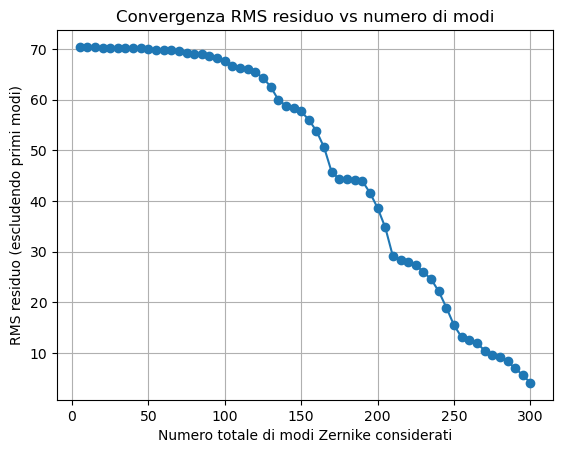

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Suppongo che R, Theta, mask siano già calcolati come nel tuo script,
# e zernike_basis(nterms, rho, theta) restituisca la lista di matrici.
# files e parsing sono già stati gestiti: hai wavefront_data, pupil, ecc.

def compute_residual_rms(max_modes, exclude_low=4):
    """
    max_modes: numero totale di modi Zernike da includere (in base Noll).
    exclude_low: quanti primi modi escludere (es. 3 per piston/tip/tilt, o 4 per defocus).
    Ritorna RMS residuo.
    """
    # Costruisci base completa fino a max_modes:
    basis = zernike_basis(nterms=max_modes, rho=R, theta=Theta)  # lista di array shape grid
    # Rimuovi i modi bassi
    basis_trim = basis[exclude_low:]  # includi da Z(exclude_low+1) fino a max_modes
    n_trim = len(basis_trim)
    # Monta matrice solo per punti dentro pupilla
    Zmat = np.vstack([b[mask] for b in basis_trim]).T  # shape (Npix, n_trim)
    # Fit ai dati (solo punti maskati)
    coeffs, *_ = np.linalg.lstsq(Zmat, wavefront_data[mask], rcond=None)
    # Ricostruzione e residuo
    fit_vals = np.sum([coeffs[j] * basis_trim[j][mask] for j in range(n_trim)], axis=0)
    residual = wavefront_data[mask] - fit_vals
    # RMS residuo
    rms = np.sqrt(np.mean(residual**2))
    return rms

# Definisci un intervallo di max_modes da testare, ad esempio da 5 a 50:
# Nota: max_modes qui è il numero totale di termini nella base prima di escludere i bassi.
mode_list = list(range(5, 301, 5))  # [5,10,15,...,50]
rms_list = []

for m in mode_list:
    rms = compute_residual_rms(max_modes=m, exclude_low=3)
    rms_list.append(rms)

# Plot
plt.figure()
plt.plot(mode_list, rms_list, marker='o')
plt.xlabel("Numero totale di modi Zernike considerati")
plt.ylabel("RMS residuo (escludendo primi modi)")
plt.title("Convergenza RMS residuo vs numero di modi")
plt.grid(True)
plt.show()


# Decompose.opd

(45, 74)


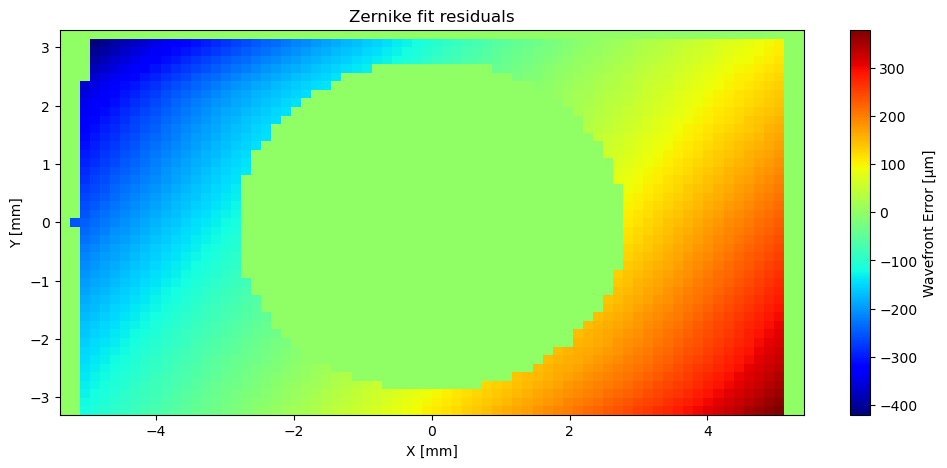

In [99]:

wavefront_fit_2 = np.nan_to_num(wavefront_fit_2, nan=0.0)
print(wavefront_fit_2.shape)
# Replace NaN values in residuals with 0.0 for plotting
residuals = np.nan_to_num(wavefront_data - wavefront_fit_2, nan=0.0)

plot_wavefront_new(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], residuals, title='Zernike fit residuals')